In [1]:
# import dicom2nifti
import nibabel as nib
# import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os

In [16]:
dir_path = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/anatomical-images'
os.listdir(dir_path)

['sub03_T1.nii']

In [19]:
brain_vol = nib.load(f'{dir_path}/sub03_T1.nii')
print(f'datatype of brain_vol: {type(brain_vol)}')

# get data from brain_vol
brain_vol_data = brain_vol.get_fdata()
print(f'datatype of brain_vol_data: {type(brain_vol_data)}')
print(f'shape of volume: {brain_vol_data.shape}')

datatype of brain_vol: <class 'nibabel.nifti1.Nifti1Image'>
datatype of brain_vol_data: <class 'numpy.memmap'>
shape of volume: (256, 256, 256)


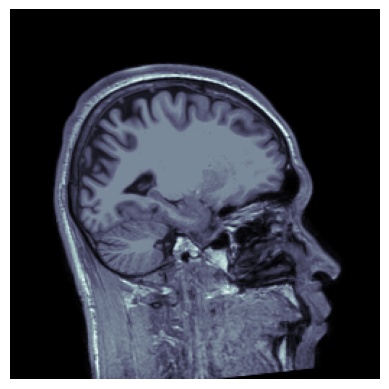

In [28]:
plt.imshow(brain_vol_data[150], cmap='bone')
plt.axis('off')
plt.show()

### Plot using Nilearn

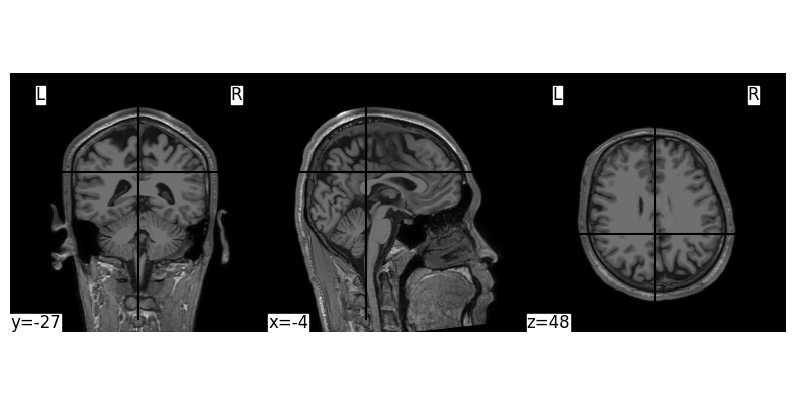

In [29]:
from nilearn import plotting

fig, ax = plt.subplots(figsize=[10, 5])
plotting.plot_img(brain_vol, cmap='gray', axes=ax)
plt.show()

### Load freesurfer annotations file

In [2]:
hemi = 'lh'
file = f'./vep-atlas/sub03/label/{hemi}.aparc.vep.annot'

nib.freesurfer.io.read_annot(file)

(array([69, 69, 69, ..., 56, 18,  1], dtype='>i4'),
 array([[       0,        0,        0,        0,        0],
        [     239,       95,       12,        0,   810991],
        [     196,       10,       64,        0,  4197060],
        [     169,      225,      204,        0, 13427113],
        [     183,      140,      191,        0, 12553399],
        [     255,      255,       32,        0,  2162687],
        [      78,      116,       95,        0,  6255694],
        [     175,       18,      177,        0, 11604655],
        [     201,       63,      115,        0,  7552969],
        [     210,       38,       12,        0,   796370],
        [      55,      249,      219,        0, 14416183],
        [      16,      164,       76,        0,  5022736],
        [     213,      155,      164,        0, 10787797],
        [     213,       16,      136,        0,  8917205],
        [      79,      252,      131,        0,  8649807],
        [     109,      135,       75,        0,

### MNE Brain Parcellations and Electrode Porjection onto Brain Example

In [1]:
%matplotlib qt5
%gui qt5

# import pyvista
# pyvista.start_xvfb()
# import mne 
# mne.viz.set_3d_backend("notebook")

import os
import os.path as op
import numpy as np
import mne
import imageio

misc_path = mne.datasets.misc.data_path()
sample_path = mne.datasets.sample.data_path()
subjects_dir = misc_path / 'seeg'
subject = 'sample_seeg'

raw = mne.io.read_raw(misc_path / 'seeg' / 'sample_seeg_ieeg.fif')
trans = mne.coreg.estimate_head_mri_t('sample_seeg', subjects_dir)

view_kwargs = dict(azimuth=120, elevation=100, distance=600,
                   focalpoint=(0, 0, -15))

proj_info = mne.preprocessing.ieeg.project_sensors_onto_brain(
    raw.info, trans, subject, subjects_dir=subjects_dir, picks='seeg')

surf_data = dict(lh=dict(), rh=dict())
x_dir = np.array([1., 0., 0.])
for hemi in ('lh', 'rh'):
    for surf in ('pial', 'inflated', 'curv'):
        for img in ('', '.T1', '.T2', ''):
            surf_fname = op.join(subjects_dir, subject, 'surf',
                                 f'{hemi}.{surf}')
            if op.isfile(surf_fname):
                break
        if surf == 'curv':
            surf_data[hemi]['curv'] = np.array(mne.surface.read_curvature(
                surf_fname, binary=False) > 0, np.int64)
        else:
            coords, faces = mne.surface.read_surface(surf_fname)
            if surf == 'inflated':
                x_ = coords @ x_dir
                coords -= np.max(x_) * x_dir if hemi == 'lh' else \
                    np.min(x_) * x_dir
            surface = dict(rr=coords, tris=faces)
            mne.surface.complete_surface_info(
                surface, copy=False, verbose=False, do_neighbor_tri=False)
            surf_data[hemi][surf] = surface['rr'], surface['tris'], surface['nn']


for hemi in ('lh', 'rh'):
    surf_data[hemi]['vectors'] = \
        surf_data[hemi]['inflated'][0] - surf_data[hemi]['pial'][0]
    surf_data[hemi]['normal_vectors'] = \
        surf_data[hemi]['inflated'][2] - surf_data[hemi]['pial'][2]

montage_start = raw.get_montage()
montage_start.apply_trans(trans)
ch_pos_start = montage_start.get_positions()['ch_pos']
montage_end = proj_info.get_montage()
montage_end.apply_trans(trans)
ch_pos_end = montage_end.get_positions()['ch_pos']

ch_pos_vectors = dict()
for ch in raw.ch_names:
    ch_pos_vectors[ch] = ch_pos_end[ch] - ch_pos_start[ch]

brain = mne.viz.Brain(subject, subjects_dir=subjects_dir,
                      cortex='low_contrast', alpha=0.5, background='white')
# brain.add_sensors(raw.info, trans=trans)
brain.show_view(**view_kwargs)

brain.add_annotation('aparc.a2009s', borders=False, alpha=0.5)

sensor_meshes = dict()
sensor_locs = dict()
for ch in raw.ch_names:
    loc = ch_pos_start[ch].copy()
    sensor_mesh = brain._renderer.sphere(loc * 1000, 'yellow', 3)[1]
    sensor_meshes[ch] = sensor_mesh
    sensor_locs[ch] = sensor_mesh.points.copy()

images = [brain.screenshot()] * 5

n_steps = 101
for t in np.linspace(0, 1, n_steps):

    for hemi in ('lh', 'rh'):
        coords, faces, nn = surf_data[hemi]['pial']
        coords = coords.copy()
        coords += surf_data[hemi]['vectors'] * t
        nn = nn.copy()
        nn += surf_data[hemi]['normal_vectors'] * t
        brain._renderer.plotter.update_coordinates(
            coords, brain._layered_meshes[hemi]._polydata, render=False)
        brain._layered_meshes[hemi]._polydata.point_data.active_normals = nn
        brain._layered_meshes[hemi].update_overlay('curv', opacity=0.5 + t / 2)

    for ch, sensor_mesh in sensor_meshes.items():
        loc = sensor_locs[ch].copy()
        loc += ch_pos_vectors[ch] * t * 1000
        brain._renderer.plotter.update_coordinates(
            loc, sensor_mesh, render=False)

    brain._renderer._update()
    images.append(brain.screenshot())

for i in range(5):
    images.append(images[-1])

brain.close()
imageio.mimwrite('inflated.mp4', images, fps=24)


Opening raw data file C:\Users\matti\mne_data\MNE-misc-data\seeg\sample_seeg_ieeg.fif...
    Range : 1310640 ... 1370605 =   1311.411 ...  1371.411 secs
Ready.
Using pyvistaqt 3d backend.



c:\Users\matti\miniconda3\envs\mne\Lib\site-packages\pyvista\plotting\plotter.py:4722: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(
c:\Users\matti\miniconda3\envs\mne\Lib\site-packages\pyvista\plotting\plotter.py:4722: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(
c:\Users\matti\miniconda3\envs\mne\Lib\site-packages\pyvista\plotting\plotter.py:4722: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(
c:\Users\matti\miniconda3\envs\mne\Lib\site-packages\pyvista\plotting\plotter.py:4722: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify 

# Use VEP-atlas brain parcellation for contact localization

In [1]:
import neuropsy as npsy

# Define paths
path_data = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subjects_dir = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/'
vepLUTfname = "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/VEP_atlas_shared/data/VepFreeSurferColorLut.txt"

# Define variables
subject_id = '03'
subject_dir_name = f'sub{subject_id}'


# Load data
data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
data.load(load_saved=True, postfix='preprocessed')

# create MNE raw object within data class
data.create_raw()

# data._add_montage(subjects_dir=subjects_dir)

# aseg = "vep.aparc+aseg"
# labels, colors = npsy.utils.get_vep_atlas(montage=data.raw.get_montage(), subject=subject_dir_name, subjects_dir=subjects_dir, aseg=aseg, dist=.2, fname=vepLUTfname)

# find and add VEP atlas labels to channel dataframe
aseg = "vep.aparc+aseg"
data.add_vep_atlas_labels_to_df_chan(subjects_dir=subjects_dir, aseg=aseg, fname=vepLUTfname, dist=.2)

Creating RawArray with float64 data, n_channels=83, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.


In [2]:
data.df_chan['VEP_atlas'].to_list()

['Right-Hippocampus-posterior',
 'Left-Hippocampus-posterior',
 'Left-Hippocampus-posterior',
 'Left-Hippocampus-posterior',
 'Right-STS-anterior',
 'Right-T2-anterior',
 'Unknown',
 'Left-Hippocampus-posterior',
 'Left-Hippocampus-posterior',
 'Left-Hippocampus-posterior',
 'Left-Hippocampus-posterior',
 'Unknown',
 'Right-T2-anterior',
 'Right-T2-anterior',
 'Left-Hippocampus-posterior',
 'Left-Hippocampus-posterior',
 'Left-Hippocampus-posterior',
 'Right-T1-planum-temporale',
 'Right-Cerebral-White-Matter',
 'Right-Supramarginal-anterior',
 'Unknown',
 'Right-Hippocampus-anterior',
 'Right-Hippocampus-posterior',
 'Right-Hippocampus-posterior',
 'Left-Hippocampus-posterior',
 'Right-Hippocampus-posterior',
 'Unknown',
 'Right-Angular-gyrus',
 'Right-Angular-gyrus',
 'Right-Angular-gyrus',
 'Left-Hippocampus-posterior',
 'Left-Hippocampus-posterior',
 'Right-Hippocampus-anterior',
 'Right-Cerebral-White-Matter',
 'Right-Cerebral-White-Matter',
 'Right-Cerebral-White-Matter',
 'Right

### Rename VEP "aseg" file

Because the MNE's freesurfer function to read the aseg file expects the filename to end in "...aseg.mgz" we need to rename the file output by the VEP script from _"aparc+aseg.vep.mgz"_ to _"vep.aparc+aseg.mgz"_. <br>
The relevant code from *neuropsy/data._get_montage_volume_labels()* is given below.

```
from mne._freesurfer import _get_aseg, read_freesurfer_lut
        from collections import OrderedDict

        _VOXELS_MAX = 1000  # define constant to avoid runtime issues

        if dist < 0 or dist > 10:
            raise ValueError("`dist` must be between 0 and 10")

        aseg, aseg_data = _get_aseg(aseg, subject, subjects_dir)
```

In [ ]:
import os



In [2]:
import numpy as np
import neuropsy as npsy
import re
from tqdm import tqdm

path_data       = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subjects_dir    = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/'
vepLUTfname     = "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/VEP_atlas_shared/data/VepFreeSurferColorLut.txt"
subject_ids     = npsy.utils.get_subject_ids_from_path(path_data)


for sub_id in tqdm(subject_ids, desc='Progress'):
    
    try:
        # load subject experiment data
        data = npsy.DataHandler(path=path_data, subject_id=sub_id, exp_phase=2, fs=512, verbose=False)
        data.load(load_saved=True, postfix='preprocessed', load_exp=True, load_chan=True, load_ieeg=True, load_targets=True)
        
        subject_dir_name = f'sub{sub_id}'

        # find and add VEP atlas labels to channel dataframe
        aseg = "vep.aparc+aseg"
        data.add_vep_atlas_labels_to_df_chan(subjects_dir=subjects_dir, aseg=aseg, fname=vepLUTfname, dist=.2, return_labels=False)
                    
        # save dataframe with new "VEP atlas" column
        data.save(path=path_data, postfix='vep_atlas', save_exp=False, save_ieeg=False, save_chan=True, save_targets=False, verbose=False)
    except FileNotFoundError as e:
        print(f'{e}')
        continue
    except Exception as e:
        print(f'Exception occurred: {e}')
        continue
    # break

Progress:   0%|          | 0/11 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=83, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.


Progress:   9%|▉         | 1/11 [00:06<01:00,  6.07s/it]

Creating RawArray with float64 data, n_channels=80, n_times=868110
    Range : 0 ... 868109 =      0.000 ...  1695.525 secs
Ready.


Progress:  18%|█▊        | 2/11 [00:12<00:57,  6.35s/it]

File does not exist: "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/sub04/mri/vep.aparc+aseg.mgz"
Creating RawArray with float64 data, n_channels=82, n_times=427674
    Range : 0 ... 427673 =      0.000 ...   835.299 secs
Ready.


Progress:  27%|██▋       | 3/11 [00:15<00:37,  4.72s/it]

File does not exist: "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/sub05/mri/vep.aparc+aseg.mgz"
Creating RawArray with float64 data, n_channels=85, n_times=1363811
    Range : 0 ... 1363810 =      0.000 ...  2663.691 secs
Ready.


Progress:  36%|███▋      | 4/11 [00:24<00:46,  6.57s/it]

File does not exist: "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/sub07/mri/vep.aparc+aseg.mgz"
Creating RawArray with float64 data, n_channels=94, n_times=1383831
    Range : 0 ... 1383830 =      0.000 ...  2702.793 secs
Ready.


Progress:  45%|████▌     | 5/11 [00:36<00:50,  8.42s/it]

File does not exist: "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/sub09/mri/vep.aparc+aseg.mgz"
Creating RawArray with float64 data, n_channels=84, n_times=708398
    Range : 0 ... 708397 =      0.000 ...  1383.588 secs
Ready.


Progress:  55%|█████▍    | 6/11 [00:41<00:36,  7.27s/it]

File does not exist: "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/sub10/mri/vep.aparc+aseg.mgz"
Creating RawArray with float64 data, n_channels=79, n_times=1081288
    Range : 0 ... 1081287 =      0.000 ...  2111.889 secs
Ready.


Progress:  64%|██████▎   | 7/11 [00:48<00:28,  7.03s/it]

FreeSurfer Talairach transformation file does not exist: "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/sub11/mri/transforms/talairach.xfm"
Creating RawArray with float64 data, n_channels=86, n_times=998554
    Range : 0 ... 998553 =      0.000 ...  1950.299 secs
Ready.


Progress:  73%|███████▎  | 8/11 [00:55<00:21,  7.16s/it]

File does not exist: "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/sub12/mri/vep.aparc+aseg.mgz"
Creating RawArray with float64 data, n_channels=81, n_times=647222
    Range : 0 ... 647221 =      0.000 ...  1264.104 secs
Ready.


Progress:  82%|████████▏ | 9/11 [01:00<00:12,  6.44s/it]

File does not exist: "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/sub14/mri/vep.aparc+aseg.mgz"
Creating RawArray with float64 data, n_channels=95, n_times=845938
    Range : 0 ... 845937 =      0.000 ...  1652.221 secs
Ready.


Progress:  91%|█████████ | 10/11 [01:10<00:07,  7.43s/it]

FreeSurfer Talairach transformation file does not exist: "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/sub15/mri/transforms/talairach.xfm"
Creating RawArray with float64 data, n_channels=96, n_times=1018626
    Range : 0 ... 1018625 =      0.000 ...  1989.502 secs
Ready.


Progress: 100%|██████████| 11/11 [01:19<00:00,  7.25s/it]

FreeSurfer Talairach transformation file does not exist: "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/sub19/mri/transforms/talairach.xfm"


In [5]:
import neuropsy as npsy
import mne
import numpy as np
from mne.io.constants import FIFF
import matplotlib.pyplot as plt

# Define paths
# path_data = 'C:/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
# subjects_dir = 'C:/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/'
path_data = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subjects_dir = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/vep-atlas/'

# Define variables
subject_id = '03'
subject_dir_name = f'sub{subject_id}'


# Load data
data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
data.load(load_saved=True, postfix='preprocessed')

# create MNE raw object within data class
data.create_raw()


# get fiducialsin for subject in MNI_TAL space using subject's Freesurfer MRI brian
fiducials = mne.coreg.get_mni_fiducials(subject=subject_dir_name, subjects_dir=subjects_dir)

for d in fiducials:
    if d["ident"] == FIFF.FIFFV_POINT_NASION:
        nas = d['r'] #* 1000
    elif d["ident"] == FIFF.FIFFV_POINT_LPA:
        lpa = d['r'] #* 1000
    elif d["ident"] == FIFF.FIFFV_POINT_RPA:
        rpa = d['r'] #* 1000

# get channel locations from channel meta information dataframe
ch_locations = {}
for ch in data.df_chan['name']:
    ch_locations[ch] = tuple(data.df_chan.loc[data.df_chan['name'] == ch, ['loc_1', 'loc_2', 'loc_3']].values[0])

# the location values are in mm, but MNE expects them in meters
def convert_to_meters(values):
    modified_values = np.zeros(len(values))
    for i, v in enumerate(values):
        modified_values[i] = v / 1000
    return modified_values

ch_locations_m = {key: convert_to_meters(values) for key, values in ch_locations.items()}

# create electrode locations montage
montage = mne.channels.make_dig_montage(ch_pos = ch_locations_m, nasion=nas, lpa=lpa, rpa=rpa, hsp=None, hpi=None, coord_frame = "unknown")
print(f"montage 1:\n", montage)
# apply the montage to the raw data, this will transform the coordinates to head space (under the hood)
data.raw.set_montage(montage)

# retrieve the montage from the raw data
montage = data.raw.get_montage()
print(f"montage 2:\n", montage)

# transform electrode locations from mne's head to MRI space
head_mri_t = mne.coreg.estimate_head_mri_t(subject_dir_name, subjects_dir)
montage.apply_trans(head_mri_t)
print(f"montage 3:\n", montage)

# now let's load our Talairach transform and apply it
mri_mni_t = mne.read_talxfm(subject_dir_name, subjects_dir)
montage.apply_trans(mri_mni_t)  # mri to mni_tal (MNI Taliarach)
print(f"montage 4:\n", montage)

# for fsaverage, "mri" and "mni_tal" are equivalent and, since
# we want to plot in fsaverage "mri" space, we need use an identity
# transform to equate these coordinate frames
montage.apply_trans(mne.transforms.Transform(fro="mni_tal", to="mri", trans=np.eye(4)))
print(f"montage 5:\n", montage)
data.raw.set_montage(montage)

print(f"montage 6:\n", data.raw.get_montage())

Creating RawArray with float64 data, n_channels=83, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.
montage 1:
 <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 83 channels>
montage 2:
 <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 83 channels>
montage 3:
 <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 83 channels>
montage 4:
 <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 83 channels>
montage 5:
 <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 83 channels>
montage 6:
 <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 83 channels>


In [9]:
data.df_chan

,elec_index,elec_label,DK_ROI,Prob,Lobe,x17Networks,Prob_1,x7Networks,Prob_2,BN_atlas,...,perc_VTPM,Prob_5,Var16,data_chan,loc_1,loc_2,loc_3,name,HC left,HC right
0,2,102,Right_Amygdala,1.00,A,NO_ROI,0.00,NO_ROI,0.00,Amyg_R_2_2,...,NO_ROI,0.0,NaN,2,12.873248,8.506878,8.306705,A' 02,False,False
1,3,103,Right_Amygdala,1.00,A,NO_ROI,0.00,NO_ROI,0.00,Amyg_R_2_2,...,NO_ROI,0.0,NaN,3,16.039387,9.619074,7.336206,A' 03,False,False
2,4,104,Right_Amygdala,0.79,A,NO_ROI,0.00,NO_ROI,0.00,Amyg_R_2_2,...,NO_ROI,0.0,NaN,4,19.141373,10.709271,6.404444,A' 04,False,False
3,5,105,Right_Cerebral_White_Matter,0.54,W,NO_ROI,0.00,NO_ROI,0.00,Amyg_R_2_2,...,NO_ROI,0.0,NaN,5,22.355613,11.835152,5.453657,A' 05,False,False
4,10,110,Right_Cerebral_White_Matter,0.60,W,NO_ROI,0.00,NO_ROI,0.00,MTG_R_4_2,...,NO_ROI,0.0,NaN,6,38.617763,17.329839,0.770212,A' 10,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,133,1005,Right_Cerebral_White_Matter,0.77,W,Networks_9,0.88,Networks_5,0.88,FuG_R_3_1,...,NO_ROI,0.0,NaN,98,31.402414,9.604975,-5.149381,P' 05,False,False
79,134,1006,ctx_rh_inferiortemporal,0.35,T,NO_ROI,0.00,NO_ROI,0.00,ITG_R_7_4,...,NO_ROI,0.0,NaN,99,34.253232,11.781723,-5.483623,P' 06,False,False
80,135,1007,ctx_rh_middletemporal,0.46,T,Networks_17,0.67,Networks_7,0.50,MTG_R_4_2,...,NO_ROI,0.0,NaN,100,36.986022,13.911336,-5.812496,P' 07,False,False
81,136,1008,ctx_rh_middletemporal,0.65,T,Networks_17,0.96,Networks_7,0.89,MTG_R_4_2,...,NO_ROI,0.0,NaN,101,39.725501,16.124890,-6.160783,P' 08,False,False


In [3]:
Brain = mne.viz.get_brain_class()
brain = Brain(
    subject_dir_name, hemi="lh", surf="pial", subjects_dir=subjects_dir, size=(800, 600)
)
brain.add_annotation("aparc.a2009s", borders=False)

Using pyvistaqt 3d backend.



: 

In [2]:
Brain = mne.viz.get_brain_class()
brain = Brain(
    subject_dir_name, hemi="lh", surf="pial", subjects_dir=subjects_dir, size=(800, 600)
)
brain.add_annotation("aparc.vep", borders=False)

Using pyvistaqt 3d backend.



In [4]:
# compute the transform to head for plotting
trans = mne.channels.compute_native_head_t(montage)
# note that this is the same as:
# ``mne.transforms.invert_transform(
#      mne.transforms.combine_transforms(head_mri_t, mri_mni_t))``

view_kwargs = dict(azimuth=105, elevation=100, focalpoint=(0, 0, -15))
brain = mne.viz.Brain(
    subject=subject_dir_name,
    subjects_dir=subjects_dir,
    cortex="low_contrast",
    alpha=0.5,
    background="white",
)

# plot pial surface
# brain = mne.viz.Brain(
#     subject=subject_dir_name, subjects_dir=subjects_dir, surf="inflated", background="black"
# )

brain.add_sensors(data.raw.info, trans=trans)
# brain.add_annotation("aparc.a2009s", borders=False, alpha=0.5)
brain.add_annotation("aparc.vep", borders=False, alpha=0.5)
# brain.add_head(alpha=0.25, color="tan")
brain.show_view(distance=500, **view_kwargs)

Channel types::	seeg: 83


In [3]:
def get_montage_volume_labels(montage, subject, subjects_dir=None, aseg="auto", dist=2, fname=None):
    """Get regions of interest near channels from a Freesurfer parcellation.

    .. note:: This is applicable for channels inside the brain
              (intracranial electrodes).

    Parameters
    ----------
    %(montage)s
    %(subject)s
    %(subjects_dir)s
    %(aseg)s
    dist : float
        The distance in mm to use for identifying regions of interest.

    Returns
    -------
    labels : dict
        The regions of interest labels within ``dist`` of each channel.
    colors : dict
        The Freesurfer lookup table colors for the labels.
    """
    from mne._freesurfer import _get_aseg, read_freesurfer_lut
    from mne.channels import DigMontage
    from collections import OrderedDict
    
    _VOXELS_MAX = 1000  # define constant to avoid runtime issues

    # _validate_type(montage, DigMontage, "montage")
    # _validate_type(dist, (int, float), "dist")

    if dist < 0 or dist > 10:
        raise ValueError("`dist` must be between 0 and 10")

    aseg, aseg_data = _get_aseg(aseg, subject, subjects_dir)

    # read freesurfer lookup table
    lut, fs_colors = read_freesurfer_lut(fname=fname)
    label_lut = {v: k for k, v in lut.items()}

    # assert that all the values in the aseg are in the labels
    assert all([idx in label_lut for idx in np.unique(aseg_data)])

    # get transform to surface RAS for distance units instead of voxels
    vox2ras_tkr = aseg.header.get_vox2ras_tkr()

    ch_dict = montage.get_positions()
    if ch_dict["coord_frame"] != "mri":
        raise RuntimeError(
            "Coordinate frame not supported, expected "
            '"mri", got ' + str(ch_dict["coord_frame"])
        )
    ch_coords = np.array(list(ch_dict["ch_pos"].values()))

    # convert to freesurfer voxel space
    ch_coords = mne.surface.apply_trans(
        np.linalg.inv(aseg.header.get_vox2ras_tkr()), ch_coords * 1000
    )
    labels = OrderedDict()
    for ch_name, ch_coord in zip(montage.ch_names, ch_coords):
        if np.isnan(ch_coord).any():
            labels[ch_name] = list()
        else:
            voxels = mne.surface._voxel_neighbors(
                ch_coord,
                aseg_data,
                dist=dist,
                vox2ras_tkr=vox2ras_tkr,
                voxels_max=_VOXELS_MAX,
            )
            label_idxs = set([aseg_data[tuple(voxel)].astype(int) for voxel in voxels])
            labels[ch_name] = [label_lut[idx] for idx in label_idxs]

    all_labels = set([label for val in labels.values() for label in val])
    colors = {label: tuple(fs_colors[label][:3] / 255) + (1.0,) for label in all_labels}
    return labels, colors

aseg = "vep.aparc+aseg"
# aseg = "aparc.vep"
# vepLUTfname = "C:/Users/matti/OneDrive/Education/SDC/MasterThesis/VEP_atlas_shared/data/VepFreeSurferColorLut.txt"
vepLUTfname = "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/VEP_atlas_shared/data/VepFreeSurferColorLut.txt"
labels, colors = get_montage_volume_labels(montage, subject_dir_name, subjects_dir=subjects_dir, aseg=aseg, dist=0.2, fname=vepLUTfname)

In [3]:
montage

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 83 channels>

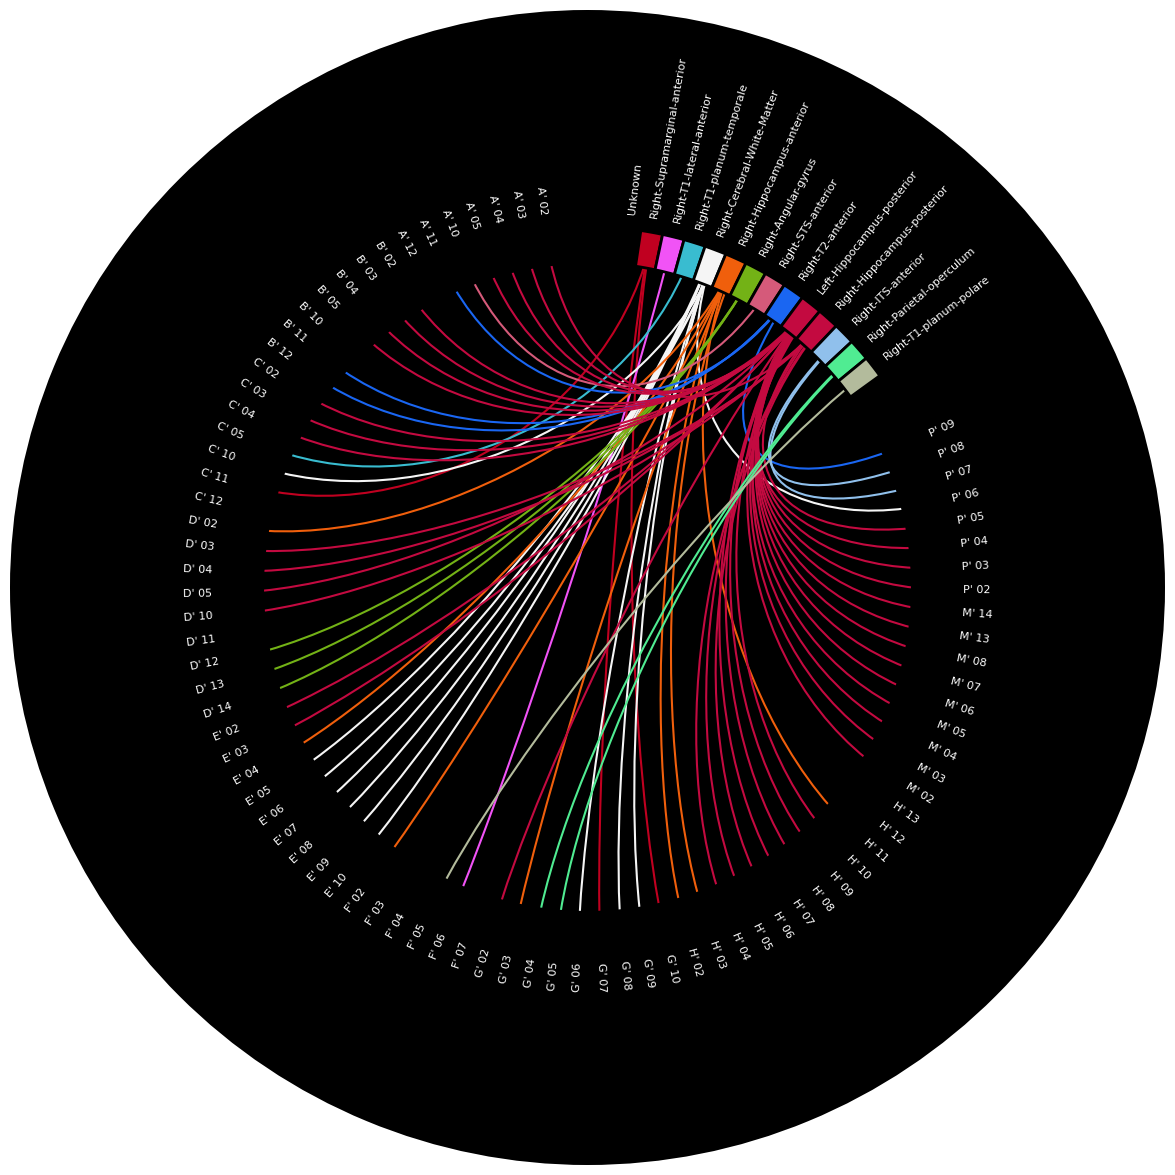

<Figure size 640x480 with 0 Axes>

In [4]:
fig, ax = plt.subplots(figsize=(20, 15), facecolor="none", subplot_kw=dict(polar=True))
kwargs = dict(ax=ax)
fig, ax = mne.viz.plot_channel_labels_circle(labels, colors, **kwargs)
fig.text(0.3, 0.9, "Anatomical Labels", color="white")
plt.tight_layout()
plt.show()

Electrodes in the dataset: {"H'", "C'", "F'", "A'", "G'", "D'", "M'", "P'", "B'", "E'"}


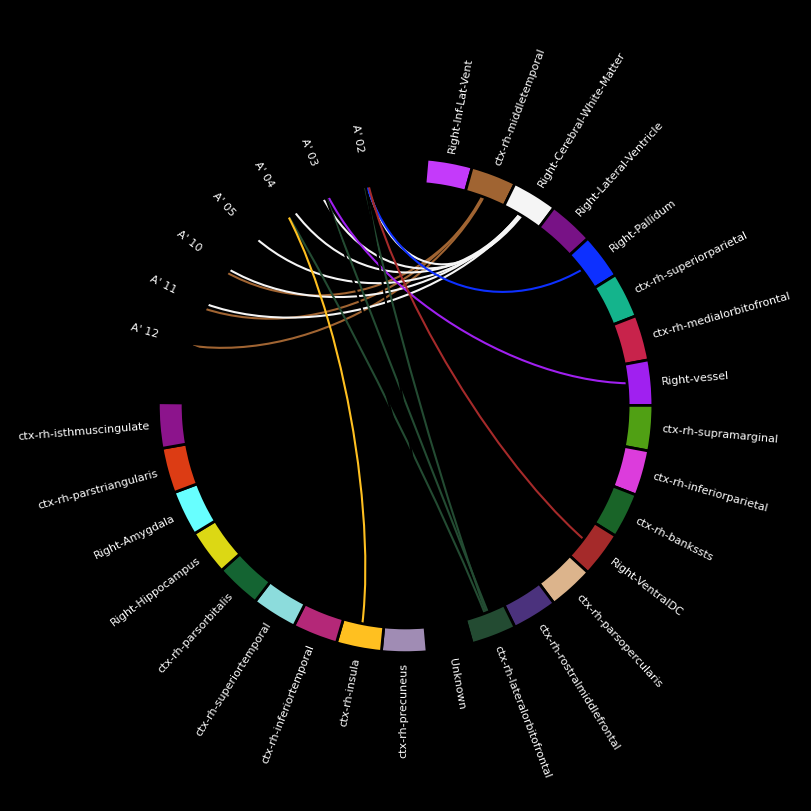

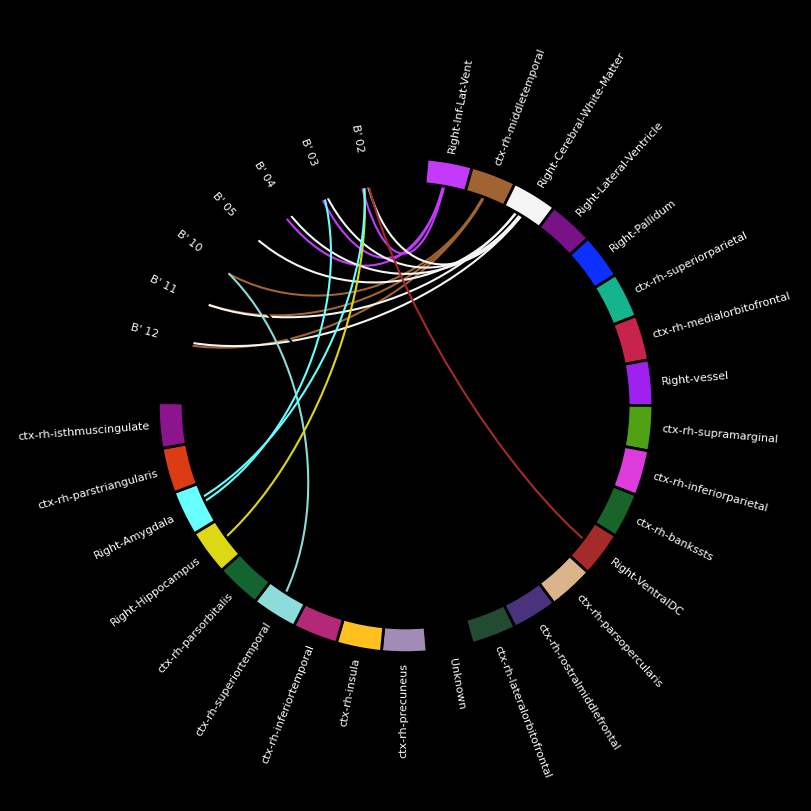

In [74]:
# aseg = "aparc+aseg"  # parcellation/anatomical segmentation atlas
# labels, colors = mne.get_montage_volume_labels(
#     montage, "fsaverage", subjects_dir=subjects_dir, aseg=aseg
# )

# separate by electrodes which have names like LAMY 1
electrodes = set(
    [
        "".join([lttr for lttr in ch_name if not lttr.isdigit() and lttr != " "])
        for ch_name in montage.ch_names
    ]
)
print(f"Electrodes in the dataset: {electrodes}")

electrodes = ("A'", "B'")  # choose two for this example
for elec in electrodes:
    picks = [ch_name for ch_name in data.raw.ch_names if elec in ch_name]
    fig, ax = mne.viz.plot_channel_labels_circle(labels, colors, picks=picks)
    fig.text(0.3, 0.9, "Anatomical Labels", color="white")

Electrodes in the dataset: {"P'", "B'", "C'", "H'", "G'", "M'", "D'", "A'", "F'", "E'"}


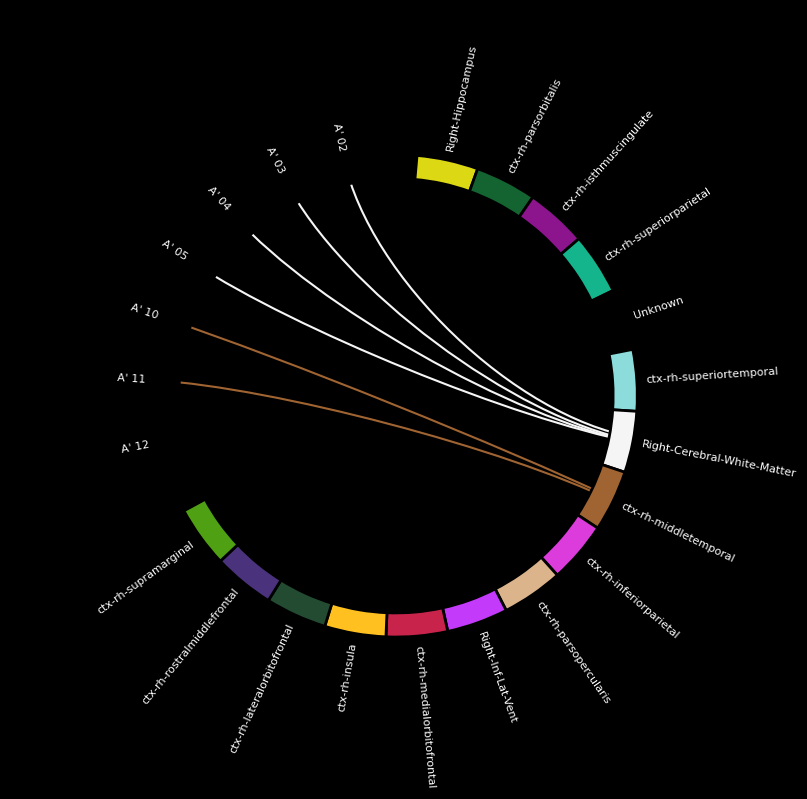

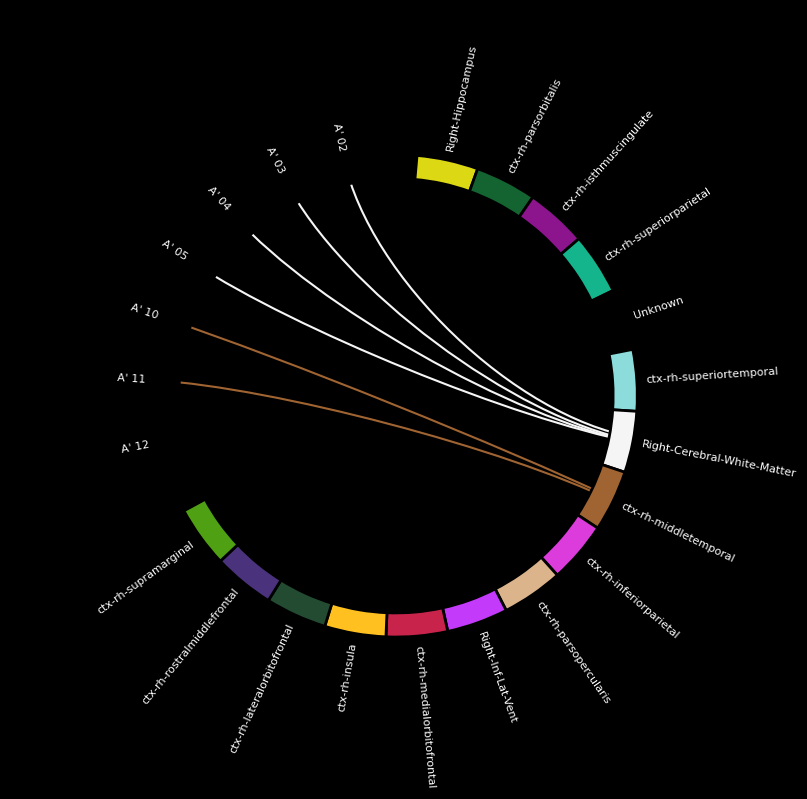

In [8]:
# separate by electrodes which have names like LAMY 1
electrodes = set(
    [
        "".join([lttr for lttr in ch_name if not lttr.isdigit() and lttr != " "])
        for ch_name in montage.ch_names
    ]
)
print(f"Electrodes in the dataset: {electrodes}")

electrodes = ("A'", "A'")  # choose two for this example
for elec in electrodes:
    picks = [ch_name for ch_name in data.raw.ch_names if elec in ch_name]
    fig, ax = mne.viz.plot_channel_labels_circle(labels, colors, picks=picks)
    fig.text(0.3, 0.9, "Anatomical Labels", color="white")

In [10]:
aseg = "vep.aparc+aseg"  # parcellation/anatomical segmentation atlas
labels, colors = mne.get_montage_volume_labels(
    montage=montage, subject=subject_dir_name, subjects_dir=subjects_dir, aseg=aseg
)

# separate by electrodes which have names like LAMY 1
electrodes = set(
    [
        "".join([lttr for lttr in ch_name if not lttr.isdigit() and lttr != " "])
        for ch_name in montage.ch_names
    ]
)
print(f"Electrodes in the dataset: {electrodes}")

electrodes = ("A' 02", "A' 03")  # choose two for this example
for elec in electrodes:
    picks = [ch_name for ch_name in data.raw.ch_names if elec in ch_name]
    fig, ax = mne.viz.plot_channel_labels_circle(labels, colors, picks=picks)
    fig.text(0.3, 0.9, "Anatomical Labels", color="white")

AssertionError: 

In [31]:
import nibabel as nib

subject_name = 'sub03'
t1 = nib.load(f'{subjects_dir}/{subject_name}/mri/T1.mgz')

torig = t1.header.get_vox2ras_tkr()
torig

array([[  -1.,    0.,    0.,  128.],
       [   0.,    0.,    1., -128.],
       [   0.,   -1.,    0.,  128.],
       [   0.,    0.,    0.,    1.]], dtype=float32)

In [25]:
head_mri_transf = mne.coreg.estimate_head_mri_t("sub03", subjects_dir)
head_mri_transf

<Transform | head->MRI (surface RAS)>
[[ 0.99832329 -0.04658278  0.03436054 -0.00611699]
 [ 0.05360971  0.96795543 -0.24533299 -0.01563791]
 [-0.02183118  0.2467637   0.96882975 -0.03196778]
 [ 0.          0.          0.          1.        ]]

In [11]:
idx = mne.pick_channels_regexp(data.raw.ch_names, '^FBR|^HM|^HL|^IAS|^IL|^HAR|^PIR|^IPR|^IAR|^CAR|^CAL|^IASR') 
# selecting 

def get_list(thelist, items):
    elements = [e for i, e in enumerate(thelist) if i in items]
    return elements

# selecting channels from info dict
locs = data.raw.info['chs']

# creating a dict with chan name and its position
pos_chanels = {}
for i in range(len(locs)):
    pos_chanels[locs[i]['ch_name']] = tuple(locs[i]['loc'][0:3])

In [12]:
pos_chanels

{"A' 02": (0.014733593006785176, 0.035319470047843804, 0.038746606538037104),
 "A' 03": (0.01821888548477672, 0.036156545007971, 0.037478728871656555),
 "A' 04": (0.02163343067390643, 0.036981742295672325, 0.03625760383944286),
 "A' 05": (0.025170871229348957, 0.037836061901999604, 0.035009694825384706),
 "A' 10": (0.043039387441492674, 0.041963806401387145, 0.028894033774477867),
 "A' 11": (0.04656097516921744, 0.042693411158308096, 0.0277197664047185),
 "A' 12": (0.05014812990568479, 0.04365876012655887, 0.02645180856597607),
 "B' 02": (0.018135625040813366, 0.026776899493058996, 0.034554328151883855),
 "B' 03": (0.021857344246213516, 0.027504114281721764, 0.0342323370766761),
 "B' 04": (0.02552779884349899, 0.02820501553079327, 0.033921595830941315),
 "B' 05": (0.029182279988814407, 0.028887059946910407, 0.033620176268315566),
 "B' 10": (0.047690568407661456, 0.03214650557152779, 0.03223711710913618),
 "B' 11": (0.05155593806270269, 0.0328000537261065, 0.03197776569288083),
 "B' 12"